Things to remember:

- Reversible computing


Binary addition 

0 + 0 = sum 0  carry 0

0+1 = sum 1 carry 0

1+0 = sum 1 carry 0

1+1 = sum 0 carry 1

1+1+1 = sum 1 carry 1

In [51]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit_aer import Aer
import numpy as np
import matplotlib.pyplot as plt

what are the building blocks of reversibility

1. the reversible xor (sum component of half adder)
     it outputs 1 if both the inputs are different and outputs 0 if both of them are same
its basically, a sum operation when carry is not involved

CNOT gate in Quantum Gates performs the XOR operation and is reversible 


2. The reversible and 
     Classical AND is irreversible so to make it reversible we use toffoli gate


In [20]:
a_val_xor = 1
b_val_xor = 0

qc_xor = QuantumCircuit(3,3)
print("Reversible XOR Circuit")
print(f"Classical Expectation: {a_val_xor} XOR {b_val_xor} = {a_val_xor ^ b_val_xor}")

Reversible XOR Circuit
Classical Expectation: 1 XOR 0 = 1


In [21]:

if a_val_xor == 1:
    qc_xor.x(0) 

if b_val_xor == 1:
    qc_xor.x(1)

In [22]:
qc_xor.barrier(label='Inputs Initialized')

CircuitInstruction(operation=Instruction(name='barrier', num_qubits=3, num_clbits=0, params=[]), qubits=(<Qubit register=(3, "q"), index=0>, <Qubit register=(3, "q"), index=1>, <Qubit register=(3, "q"), index=2>), clbits=())

In [23]:
qc_xor.cx(0, 2) 
qc_xor.cx(1, 2)

The first cx(0, 2) copies A into Qubit 2.

The second cx(1, 2) XORs B into Qubit 2. Since Qubit 2 already held A, it now holds A XOR B.

In [24]:
qc_xor.barrier(label='XOR Computed')

CircuitInstruction(operation=Instruction(name='barrier', num_qubits=3, num_clbits=0, params=[]), qubits=(<Qubit register=(3, "q"), index=0>, <Qubit register=(3, "q"), index=1>, <Qubit register=(3, "q"), index=2>), clbits=())

In [26]:
qc_xor.measure(0, 0) 
qc_xor.measure(1, 1) 
qc_xor.measure(2, 2) 


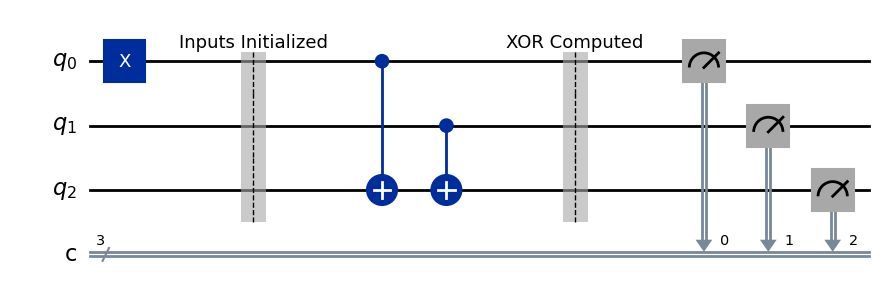

In [29]:
qc_xor.draw(output='mpl')

In [53]:
job = Aer.get_backend('qasm_simulator').run(qc_xor, shots=1024)
result = job.result()
counts_xor = result.get_counts()
print(counts_xor)

{'101': 1024}


In [31]:
from qiskit_ibm_runtime import QiskitRuntimeService

with open("ibmapi.txt", "r") as f:
    token = f.read().strip()

QiskitRuntimeService.save_account(
    token=token,
    instance="Practice",
    set_as_default=True,
    overwrite=True  # Allow overwriting the existing account
)

service = QiskitRuntimeService()

In [32]:
provider = service.backends()

In [33]:
provider

[<IBMBackend('ibm_torino')>, <IBMBackend('ibm_brisbane')>]

In [34]:
for backend in provider:
    name = backend.name
    qubits = backend.num_qubits
    status = backend.status().operational
    pending_jobs = backend.status().pending_jobs
    print(f"Backend: {name}, Qubits: {qubits}, Operational: {status}, Pending Jobs: {pending_jobs}")

Backend: ibm_torino, Qubits: 133, Operational: True, Pending Jobs: 420
Backend: ibm_brisbane, Qubits: 127, Operational: True, Pending Jobs: 2059


In [35]:
from qiskit.visualization import plot_histogram

In [ ]:
simulator = service.backend("ibm_brisbane")

In [39]:
from qiskit import transpile
transpiled_qc_xor = transpile(qc_xor, simulator)

In [40]:
from qiskit_ibm_runtime import Sampler
import time

sampler = Sampler(simulator)
# need to pass a list of circuits to `sampler.run()`, even if you have only one circuit.

job = sampler.run([transpiled_qc_xor], shots=1024)
while not job.done():
    print(f"Job is still running. Current status: {job.status()}")
    time.sleep(2)  # Wait for 10 seconds before checking again

job.wait_for_final_state()
print(f"Job completed with status: {job.status()}")

Job is still running. Current status: QUEUED
Job is still running. Current status: RUNNING
Job completed with status: DONE


In [41]:
result = job.result()

In [42]:
result[0].data

DataBin(c=BitArray(<shape=(), num_shots=1024, num_bits=3>))

In [46]:

bitvals = result[0].data.c  

counts_xor = bitvals.get_counts()

print(counts_xor)

{'101': 979, '100': 20, '001': 10, '011': 4, '000': 6, '111': 5}


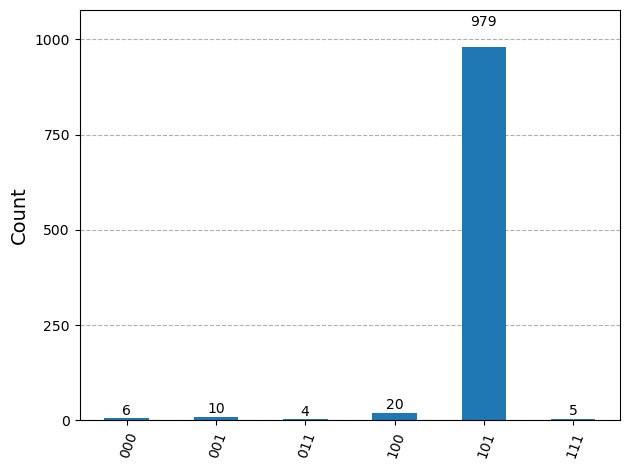

In [47]:
import matplotlib.pyplot as plt
from qiskit.visualization import plot_histogram
plot_histogram(counts_xor)

In [54]:
# Analyze the most frequent outcome (should be 100% for an ideal simulator)
most_frequent_xor = max(counts_xor.keys(), key=counts_xor.get)
measured_sum_xor = int(most_frequent_xor[0]) # Qubit 2 measurement (Sum)
measured_b_xor = int(most_frequent_xor[1])   # Qubit 1 measurement (B)
measured_a_xor = int(most_frequent_xor[2])   # Qubit 0 measurement (A)

print(f"Measured Outcome: {most_frequent_xor} (Qubit 2=Sum, Qubit 1=B, Qubit 0=A)")
print(f"  Measured A: {measured_a_xor} (Expected: {a_val_xor}) {'True' if measured_a_xor == a_val_xor else '❌'}")
print(f"  Measured B: {measured_b_xor} (Expected: {b_val_xor}) {'True' if measured_b_xor == b_val_xor else '❌'}")
print(f"  Measured Sum: {measured_sum_xor} (Expected: {a_val_xor ^ b_val_xor}) {'True' if measured_sum_xor == (a_val_xor ^ b_val_xor) else '❌'}")


Measured Outcome: 101 (Qubit 2=Sum, Qubit 1=B, Qubit 0=A)
  Measured A: 1 (Expected: 1) True
  Measured B: 0 (Expected: 0) True
  Measured Sum: 1 (Expected: 1) True


Crucial for Reversibility: Inputs A and B are preserved

Inputs A and B remain unchanged throughout the computation.

This is a key property of reversible gates like CNOT

Implementing reversible and gate